In [1]:
import requests
import s3fs
from pprint import pprint
import xarray as xr
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from tqdm import tqdm
import pyresample as pr
from pyresample.kd_tree import resample_gauss

#to make big figures
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
#select L2 data: 
dataset='podaac-ops-cumulus-protected/ASCATA-L2-25km'
shortname='ASCATA-L2-25km'

#timeframe of interest:
start_date = '2015-09-15T00:00:00Z'
end_date   = '2015-09-15T23:59:59Z'

#region of interest:
lonmin = -170.0
latmin = 65.0
lonmax = -120.0
latmax = 80.0

In [3]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

In [4]:
provider = 'POCLOUD'
response = requests.get(url,
                        params={
                            'short_name': shortname,
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 251,
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
collections = response.json()['feed']['entry']
for collection in collections:
    print(f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}')

NASA/JPL/PODAAC MetOp-A ASCAT Level 2 25.0 km Ocean Surface Wind Vectors C2075141524-POCLOUD


In [5]:
concept_id='C2075141524-POCLOUD' #get the concept ID from earthdata website, clicking on the dataset, looking at the http link: https://search.earthdata.nasa.gov/search/granules/collection-details?p=C2075141524-POCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&q=L2&ff=Available%20from%20AWS%20Cloud&fi=ASCAT&fl=2%20-%20Geophys.%20Variables%2C%20Sensor%20Coordinates&tl=1637188235.263!3!!&m=8.456485070842092!-75.234375!1!1!0!0%2C2
url = f'{CMR_OPS}/{"granules"}'
spacebox=str(lonmin)+','+str(latmin)+','+str(lonmax)+','+str(latmax) #SW lon, SW lat, NE lon, NE lat
tempbox=f'{start_date},{end_date}'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': tempbox,
                            'bounding_box': spacebox,
                            'page_size': 228,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['cmr-hits'])

200
15


In [6]:
granules = response.json()['feed']['entry']
urls = []
for granule in granules:
    # print(granule['boxes'], granule['links'][0]['href'])
    urls.append(granule['links'][0]['href'])
print(urls[0])

s3://podaac-ops-cumulus-protected/ASCATA-L2-25km/ascat_20150914_232400_metopa_46205_eps_o_250_2300_ovw.l2.nc


In [7]:
#s3fs
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials'}

def get_temp_creds():
    temp_creds_url = s3_cred_endpoint['podaac']
    return requests.get(temp_creds_url).json()

temp_creds_req = get_temp_creds()

s3_client = s3fs.S3FileSystem(anon=False,key=temp_creds_req['accessKeyId'], secret=temp_creds_req['secretAccessKey'], token=temp_creds_req['sessionToken'])
print(s3_client)

In [8]:
contents = s3_client.ls(dataset)
# contents
pprint(contents[0:3])
ds = xr.open_dataset(s3_client.open(contents[0]))
ds

['podaac-ops-cumulus-protected/ASCATA-L2-25km/ascat_20070328_000002_metopa_02263_eps_t_250_0100_ovw.l2.nc',
 'podaac-ops-cumulus-protected/ASCATA-L2-25km/ascat_20070328_000002_metopa_02263_eps_t_250_0100_ovw.l2.nc.dmrpp',
 'podaac-ops-cumulus-protected/ASCATA-L2-25km/ascat_20070328_010003_metopa_02264_eps_t_250_0100_ovw.l2.nc']


<xarray.Dataset>
Dimensions:           (NUMROWS: 958, NUMCELLS: 42)
Coordinates:
    lat               (NUMROWS, NUMCELLS) float64 ...
    lon               (NUMROWS, NUMCELLS) float64 ...
Dimensions without coordinates: NUMROWS, NUMCELLS
Data variables:
    time              (NUMROWS, NUMCELLS) datetime64[ns] ...
    wvc_index         (NUMROWS, NUMCELLS) float32 ...
    model_speed       (NUMROWS, NUMCELLS) float32 ...
    model_dir         (NUMROWS, NUMCELLS) float32 ...
    ice_prob          (NUMROWS, NUMCELLS) float32 ...
    ice_age           (NUMROWS, NUMCELLS) float32 ...
    wvc_quality_flag  (NUMROWS, NUMCELLS) float64 ...
    wind_speed        (NUMROWS, NUMCELLS) float32 ...
    wind_dir          (NUMROWS, NUMCELLS) float32 ...
    bs_distance       (NUMROWS, NUMCELLS) float32 ...
Attributes: (12/29)
    title:                            MetOp-A ASCAT Level 2 25.0 km Ocean Sur...
    title_short_name:                 ASCAT-L2-25km
    Conventions:                      CF-1.4
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-A ASCAT
    software_identification_level_1:  [0]
    ...                               ...
    orbit_inclination:                98.7
    history:                          N/A
    references:                       ASCAT Wind Product User Manual, http://...
    comment:                          Orbit period and inclination are consta...
    creation_date:                    2009-12-10
    creation_time:                    08:35:51

In [9]:
def _open_mfdataset(urls: list): #from Jack, don't understand all, a simple concatenation with mfdataset was not working

    def _open_dataset(x):
        return xr.open_dataset(s3_client.open(x), 
                               decode_cf=False,
                               decode_coords=True,
                               mask_and_scale=True, )

    return xr.concat(list(map(lambda x: _open_dataset(x), tqdm(urls))), 
                     dim="NUMROWS",
                     data_vars=['wind_speed','time'],
                     fill_value=numpy.nan, ).set_coords(['lat', 'lon'])
ds = _open_mfdataset(sorted(urls))

print(ds)

100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


<xarray.Dataset>
Dimensions:           (NUMROWS: 24288, NUMCELLS: 42)
Coordinates:
    lat               (NUMROWS, NUMCELLS) float32 8.306 8.361 ... 3.164 3.212
    lon               (NUMROWS, NUMCELLS) float32 321.9 322.1 ... 318.9 319.1
Dimensions without coordinates: NUMROWS, NUMCELLS
Data variables:
    time              (NUMROWS, NUMCELLS) int32 811121040 ... 811212116
    wvc_index         (NUMROWS, NUMCELLS) int16 1 2 3 4 5 6 ... 38 39 40 41 42
    model_speed       (NUMROWS, NUMCELLS) float32 4.76 4.75 4.76 ... 8.67 8.73
    model_dir         (NUMROWS, NUMCELLS) float32 342.5 341.0 ... 299.7 299.5
    ice_prob          (NUMROWS, NUMCELLS) float32 1e+30 1e+30 ... 1e+30 1e+30
    ice_age           (NUMROWS, NUMCELLS) float32 1e+30 1e+30 ... 1e+30 1e+30
    wvc_quality_flag  (NUMROWS, NUMCELLS) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    wind_speed        (NUMROWS, NUMCELLS) float32 6.7 6.53 6.49 ... 8.38 8.5
    wind_dir          (NUMROWS, NUMCELLS) float32 350.1 348.8 ... 300.8 29

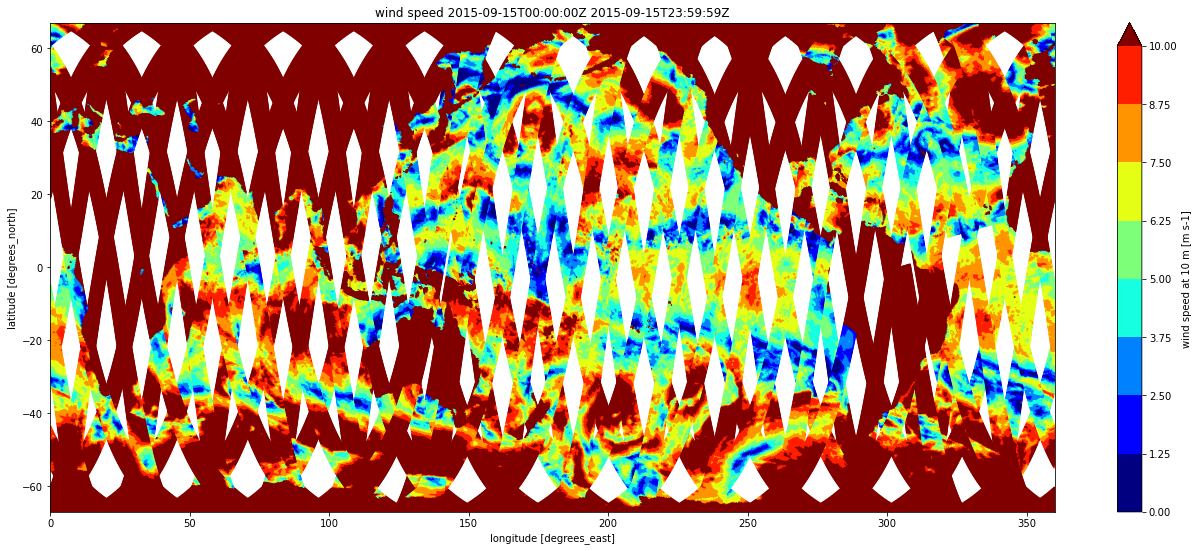

In [10]:
ds.plot.scatter( y="lat",
                 x="lon", 
                 hue="wind_speed",
                 s=1,
                 vmin=0,
                 vmax=10,
                 levels=9, 
                 cmap="jet",
                 aspect=2.5,
                 size=9, )

plt.title(f'wind speed {start_date} {end_date}')
plt.xlim(  0., 360.)
plt.ylim(-67.,  67.)
plt.show()

In [11]:
wind_speed=ds.wind_speed
attrs = {}
for k, v in ds.wind_speed.attrs.items():
        if isinstance(v, bytes):
            attrs[k] = v.decode('utf-8')
        else:
            attrs[k] = v
attrs['_FillValue']
wind_speed = numpy.where(ds.wind_speed < attrs['_FillValue'], ds.wind_speed, numpy.nan)
wind_speed

array([[6.7 , 6.53, 6.49, ..., 5.59, 5.61, 5.62],
       [6.87, 6.74, 6.55, ..., 5.6 , 5.67, 5.52],
       [6.89, 6.71, 6.49, ..., 5.38, 5.45, 5.35],
       ...,
       [ nan,  nan,  nan, ..., 8.74, 8.68, 8.64],
       [ nan,  nan,  nan, ..., 8.63, 8.65, 8.52],
       [ nan,  nan,  nan, ..., 8.25, 8.38, 8.5 ]], dtype=float32)

In [12]:
# [LO,LA]=numpy.meshgrid(ds.lon,ds.lat)
# fig = plt.figure(figsize=(15,12))
# ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-150))  # Orthographic
# extent = [-180,180,-90,90]
# ax.set_extent(extent, crs=ccrs.PlateCarree())
# plt.set_cmap(cmap=plt.get_cmap('turbo'))
# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# ax.coastlines()
# ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
# cs = ax.scatter(LO,LA,wind_speed,vmin=0,vmax=10,transform=ccrs.PlateCarree(),shading='auto')
# cb = plt.colorbar(cs,fraction = 0.022,extend='both')
# cb.set_label('wind_speed',fontsize = 10)

In [13]:
#load a dataset gridded that will be our grid
dataset2='podaac-ops-cumulus-protected/OISSS_L4_multimission_7day_v1'
contents = s3_client.ls(dataset2)[0]
contents
file = s3_client.open(contents)
ds_grid = xr.open_dataset(file)
ds_grid

<xarray.Dataset>
Dimensions:          (longitude: 1440, latitude: 720, time: 1)
Coordinates:
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time             (time) datetime64[ns] 2011-08-28
Data variables:
    sss              (latitude, longitude, time) float32 ...
    sss_uncertainty  (latitude, longitude, time) float32 ...
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v1
    Version:                       V1.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     [0.25]
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            [-180.]
    geospatial_lon_max:            [180.]
    geospatial_lon_resolution:     [0.25]
    geospatial_lon_units:          degrees_east

In [14]:
longrid = ds_grid.longitude.values
latgrid = ds_grid.latitude.values

LOgrid, LAgrid = numpy.meshgrid(longrid, latgrid)

print(LOgrid.shape,LAgrid.shape)


(720, 1440) (720, 1440)


In [15]:
target = pr.SwathDefinition(LOgrid, LAgrid)

In [16]:
nnans = ~numpy.isnan(wind_speed)
wind_speed = wind_speed[nnans]

lons = ds.lon.values[nnans]
lats = ds.lat.values[nnans]  
lons = (lons + 180) % 360 - 180
print(wind_speed.shape, lons.shape, lats.shape)

(544054,) (544054,) (544054,)


In [17]:
source = pr.SwathDefinition(lons, lats)

In [18]:
result, stddev, counts = resample_gauss(
    source,
    wind_speed,
    target,
    radius_of_influence=175000,  
    sigmas=25000,
    neighbours=100,
    fill_value=numpy.nan,
    with_uncert=True,
)
result.shape

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 175000 m for some data points
  warnings.warn(('Possible more than %s neighbours '
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyresample/kd_tree.py:811: RuntimeWarning: divide by zero encountered in true_divide
  (v1 / (v1 ** 2 - v2)) * stddev[new_valid_index])


(720, 1440)

In [19]:
def to_xrda(data):
    return xr.DataArray(data,
                        dims=['latitude', 'longitude'], 
                        coords={'latitude': latgrid, 
                                'longitude': longrid})

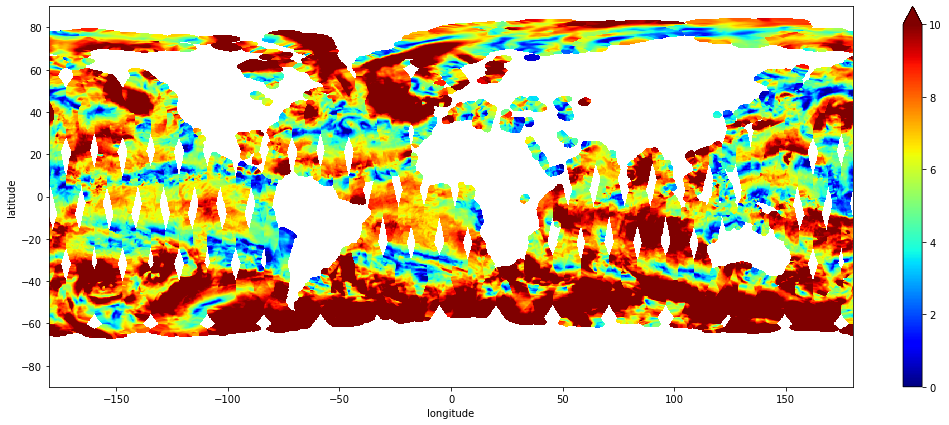

In [20]:
grid = to_xrda(result)
grid.plot(vmin=0, vmax=10, cmap="jet", figsize=(18, 7))